## Load and Prepare Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/layoffs_modeling_ready.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nTarget distribution:\n{df['Layoff_Event_Binary'].value_counts()}")
print(f"Class balance: {df['Layoff_Event_Binary'].mean():.4f}")

Dataset shape: (2736, 62)
Date range: 2020-01-01 00:00:00 to 2024-04-01 00:00:00

Target distribution:
0.0    2441
1.0     295
Name: Layoff_Event_Binary, dtype: int64
Class balance: 0.1078


## Prepare Features and Target

In [3]:
exclude_cols = ['Company', 'Date', 'year', 'quarter', 'year_quarter', 'Latest_Country', 'Layoff_Event_Binary']

feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['Layoff_Event_Binary']

print(f"Final features: {len(feature_cols)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")

Final features: 55
X shape: (2736, 55)
y shape: (2736,)
Missing values: 0


## Temporal Train-Test Split

In [4]:
split_date = '2023-07-01' 

train_mask = df['Date'] < split_date
test_mask = df['Date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Split date: {split_date} (Q3 2023)")
print(f"\nTrain set:")
print(f"  Size: {len(X_train)}")
print(f"  Positive class: {y_train.sum()} ({y_train.mean():.4f})")
print(f"  Date range: {df[train_mask]['Date'].min().date()} to {df[train_mask]['Date'].max().date()}")
print(f"  Quarters: Q1 2020 - Q2 2023")
print(f"\nTest set:")
print(f"  Size: {len(X_test)}")
print(f"  Positive class: {y_test.sum()} ({y_test.mean():.4f})")
print(f"  Date range: {df[test_mask]['Date'].min().date()} to {df[test_mask]['Date'].max().date()}")
print(f"  Quarters: Q3 2023 - Q1 2024")

Split date: 2023-07-01 (Q3 2023)

Train set:
  Size: 2128
  Positive class: 194.0 (0.0912)
  Date range: 2020-01-01 to 2023-04-01
  Quarters: Q1 2020 - Q2 2023

Test set:
  Size: 608
  Positive class: 101.0 (0.1661)
  Date range: 2023-07-01 to 2024-04-01
  Quarters: Q3 2023 - Q1 2024


## Scale Features

In [5]:
continuous_features = [col for col in feature_cols if not col.startswith(('Industry_', 'Stage_', 'negative_', 'declining_')) and col != 'layoff_event_lag1']
binary_features = [col for col in feature_cols if col.startswith(('Industry_', 'Stage_', 'negative_', 'declining_')) or col == 'layoff_event_lag1']

print(f"Continuous features to scale: {len(continuous_features)}")
print(f"Binary features (no scaling): {len(binary_features)}")

scaler = StandardScaler()

X_train_continuous = scaler.fit_transform(X_train[continuous_features])
X_test_continuous = scaler.transform(X_test[continuous_features])

X_train_scaled = np.hstack([X_train_continuous, X_train[binary_features].values])
X_test_scaled = np.hstack([X_test_continuous, X_test[binary_features].values])

feature_names = continuous_features + binary_features

print(f"\nScaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")
print(f"Train mean: {X_train_scaled.mean():.6f}")
print(f"Train std: {X_train_scaled.std():.6f}")

Continuous features to scale: 29
Binary features (no scaling): 26

Scaled train shape: (2128, 55)
Scaled test shape: (608, 55)
Train mean: 0.075197
Train std: 0.772538


## Baseline - Decision Tree

In [6]:
from sklearn.metrics import fbeta_score

dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)

train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)
test_f1_dt = f1_score(y_test, y_test_pred_dt)
test_f2_dt = fbeta_score(y_test, y_test_pred_dt, beta=2)

print("Decision Tree Results:")
print(f"  Train Accuracy: {train_acc_dt:.4f}")
print(f"  Test Accuracy: {test_acc_dt:.4f}")
print(f"  Test F1-Score: {test_f1_dt:.4f}")
print(f"  Test F2-Score: {test_f2_dt:.4f}")

print(f"\nTest Confusion Matrix:")
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
print(cm_dt)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_dt, target_names=['No Layoff', 'Layoff']))

print(f"\nTop 10 Feature Importances:")
importances_dt = dt_model.feature_importances_
indices = np.argsort(importances_dt)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_dt[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_dt[idx]:.4f}")

Decision Tree Results:
  Train Accuracy: 1.0000
  Test Accuracy: 0.7484
  Test F1-Score: 0.3260
  Test F2-Score: 0.3491

Test Confusion Matrix:
[[418  89]
 [ 64  37]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.87      0.82      0.85       507
      Layoff       0.29      0.37      0.33       101

    accuracy                           0.75       608
   macro avg       0.58      0.60      0.59       608
weighted avg       0.77      0.75      0.76       608


Top 10 Feature Importances:
  Latest_Funds_Raised_Log: 0.4330
  unemployment_rate_lag1: 0.1324
  quarters_since_last_layoff: 0.0868
  avg_jobless_claims_lag1: 0.0536
  current_assets_growth_yoy: 0.0264
  current_ratio_lag1: 0.0263
  roa_lag1: 0.0241
  debt_to_assets_lag1: 0.0221
  net_income_change_qoq: 0.0215
  stockholders_equity_growth_yoy: 0.0157


## Random Forest with Class Weights

In [7]:
from sklearn.metrics import fbeta_score

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf, zero_division=0)
test_f2_rf = fbeta_score(y_test, y_test_pred_rf, beta=2, zero_division=0)

print("Random Forest Results:")
print(f"  Train Accuracy: {train_acc_rf:.4f}")
print(f"  Test Accuracy: {test_acc_rf:.4f}")
print(f"  Test F1-Score: {test_f1_rf:.4f}")
print(f"  Test F2-Score: {test_f2_rf:.4f}")

print(f"\nTest Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print(cm_rf)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf, target_names=['No Layoff', 'Layoff'], zero_division=0))

print(f"\nTop 10 Feature Importances:")
importances_rf = rf_model.feature_importances_
indices = np.argsort(importances_rf)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_rf[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_rf[idx]:.4f}")

Random Forest Results:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8339
  Test F1-Score: 0.0000
  Test F2-Score: 0.0000

Test Confusion Matrix:
[[507   0]
 [101   0]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.83      1.00      0.91       507
      Layoff       0.00      0.00      0.00       101

    accuracy                           0.83       608
   macro avg       0.42      0.50      0.45       608
weighted avg       0.70      0.83      0.76       608


Top 10 Feature Importances:
  Latest_Funds_Raised_Log: 0.1799
  avg_jobless_claims_lag1: 0.0757
  sp500_change_6mo_lag1: 0.0621
  fed_funds_rate_lag1: 0.0495
  consumer_confidence_lag1: 0.0492
  unemployment_rate_lag1: 0.0443
  gdp_growth_rate_lag1: 0.0380
  sp500_index_lag1: 0.0375
  inflation_rate_yoy_lag1: 0.0282
  current_assets_growth_yoy: 0.0280


## XGBoost 

In [8]:
from sklearn.metrics import fbeta_score

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', 
                          scale_pos_weight=scale_pos_weight, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)

y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test, y_test_pred_xgb)
test_f2_xgb = fbeta_score(y_test, y_test_pred_xgb, beta=2)

print(f"Scale pos weight: {scale_pos_weight:.2f}")
print(f"\nXGBoost Results:")
print(f"  Train Accuracy: {train_acc_xgb:.4f}")
print(f"  Test Accuracy: {test_acc_xgb:.4f}")
print(f"  Test F1-Score: {test_f1_xgb:.4f}")
print(f"  Test F2-Score: {test_f2_xgb:.4f}")

print(f"\nTest Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print(cm_xgb)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_xgb, target_names=['No Layoff', 'Layoff']))

print(f"\nAdditional Metrics:")
print(f"  F2-Score (emphasizes recall): {test_f2_xgb:.4f}")

print(f"\nTop 10 Feature Importances:")
importances_xgb = xgb_model.feature_importances_
indices = np.argsort(importances_xgb)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_xgb[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_xgb[idx]:.4f}")

Scale pos weight: 9.97

XGBoost Results:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8586
  Test F1-Score: 0.3485
  Test F2-Score: 0.2644

Test Confusion Matrix:
[[499   8]
 [ 78  23]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.86      0.98      0.92       507
      Layoff       0.74      0.23      0.35       101

    accuracy                           0.86       608
   macro avg       0.80      0.61      0.63       608
weighted avg       0.84      0.86      0.83       608


Additional Metrics:
  F2-Score (emphasizes recall): 0.2644

Top 10 Feature Importances:
  unemployment_rate_lag1: 0.2450
  Latest_Funds_Raised_Log: 0.1463
  consumer_confidence_lag1: 0.1238
  quarters_since_last_layoff: 0.0390
  sp500_change_6mo_lag1: 0.0350
  Industry_Security: 0.0349
  Industry_Healthcare: 0.0349
  Industry_Infrastructure: 0.0248
  Stage_Post-IPO: 0.0230
  Industry_Marketing: 0.0213


## LightGBM

In [9]:
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score

lgbm_model = LGBMClassifier(random_state=42, is_unbalance=True, 
                            n_jobs=-1, verbose=-1)
lgbm_model.fit(X_train_scaled, y_train)

y_train_pred_lgbm = lgbm_model.predict(X_train_scaled)
y_test_pred_lgbm = lgbm_model.predict(X_test_scaled)

train_acc_lgbm = accuracy_score(y_train, y_train_pred_lgbm)
test_acc_lgbm = accuracy_score(y_test, y_test_pred_lgbm)
test_f1_lgbm = f1_score(y_test, y_test_pred_lgbm)
test_f2_lgbm = fbeta_score(y_test, y_test_pred_lgbm, beta=2)

print("LightGBM Results (is_unbalance=True):")
print(f"  Train Accuracy: {train_acc_lgbm:.4f}")
print(f"  Test Accuracy: {test_acc_lgbm:.4f}")
print(f"  Test F1-Score: {test_f1_lgbm:.4f}")
print(f"  Test F2-Score: {test_f2_lgbm:.4f}")

print(f"\nTest Confusion Matrix:")
cm_lgbm = confusion_matrix(y_test, y_test_pred_lgbm)
print(cm_lgbm)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_lgbm, target_names=['No Layoff', 'Layoff']))

print(f"\nTop 10 Feature Importances:")
importances_lgbm = lgbm_model.feature_importances_
indices = np.argsort(importances_lgbm)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_lgbm[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_lgbm[idx]:.4f}")

LightGBM Results (is_unbalance=True):
  Train Accuracy: 1.0000
  Test Accuracy: 0.6941
  Test F1-Score: 0.1842
  Test F2-Score: 0.1977

Test Confusion Matrix:
[[401 106]
 [ 80  21]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.83      0.79      0.81       507
      Layoff       0.17      0.21      0.18       101

    accuracy                           0.69       608
   macro avg       0.50      0.50      0.50       608
weighted avg       0.72      0.69      0.71       608


Top 10 Feature Importances:
  Latest_Funds_Raised_Log: 252.0000
  rd_to_assets_lag1: 188.0000
  current_liabilities_growth_yoy: 182.0000
  roe_lag1: 177.0000
  current_assets_growth_yoy: 163.0000
  debt_to_equity_lag1: 138.0000
  debt_to_assets_change_yoy: 137.0000
  stockholders_equity_growth_yoy: 132.0000
  net_income_change_qoq: 130.0000
  current_ratio_lag1: 129.0000


## Model Comparison Summary

In [12]:
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Test_Acc': [test_acc_dt, test_acc_rf, test_acc_xgb, test_acc_lgbm],
    'Test_F1': [test_f1_dt, test_f1_rf, test_f1_xgb, test_f1_lgbm],
    'Test_F2': [test_f2_dt, test_f2_rf, test_f2_xgb, test_f2_lgbm],
    'TP': [cm_dt[1,1], cm_rf[1,1], cm_xgb[1,1], cm_lgbm[1,1]],
    'FN': [cm_dt[1,0], cm_rf[1,0], cm_xgb[1,0], cm_lgbm[1,0]],
    'FP': [cm_dt[0,1], cm_rf[0,1], cm_xgb[0,1], cm_lgbm[0,1]]
})

results_df['Recall'] = results_df['TP'] / (results_df['TP'] + results_df['FN'])
results_df['Precision'] = results_df['TP'] / (results_df['TP'] + results_df['FP'])
results_df['Precision'] = results_df['Precision'].fillna(0)

print("Model Comparison (With Class Weights):")
print(results_df.to_string(index=False))
print(f"\nBest F1-Score: {results_df.loc[results_df['Test_F1'].idxmax(), 'Model']}")
print(f"Best F2-Score: {results_df.loc[results_df['Test_F2'].idxmax(), 'Model']}")
print(f"Best Recall: {results_df.loc[results_df['Recall'].idxmax(), 'Model']}")

Model Comparison (With Class Weights):
        Model  Test_Acc  Test_F1  Test_F2  TP  FN  FP   Recall  Precision
Decision Tree  0.748355 0.325991 0.349057  37  64  89 0.366337   0.293651
Random Forest  0.833882 0.000000 0.000000   0 101   0 0.000000   0.000000
      XGBoost  0.858553 0.348485 0.264368  23  78   8 0.227723   0.741935
     LightGBM  0.694079 0.184211 0.197740  21  80 106 0.207921   0.165354

Best F1-Score: XGBoost
Best F2-Score: Decision Tree
Best Recall: Decision Tree


## ROC Curves

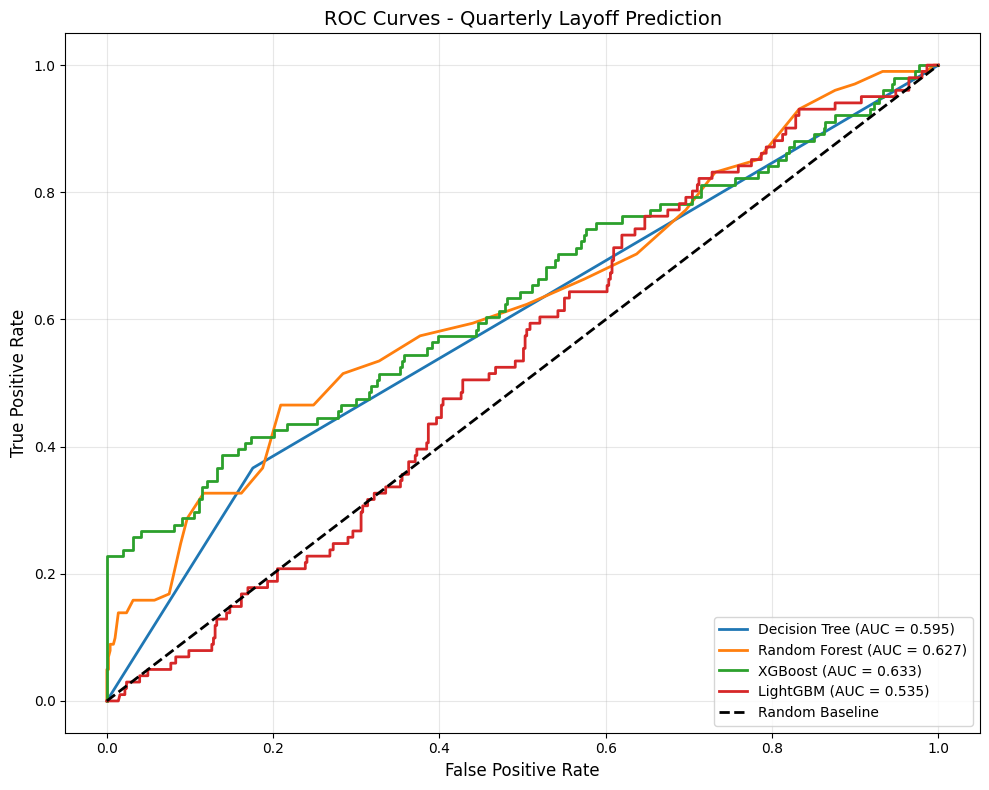

ROC AUC Scores:
  Decision Tree: 0.5954
  Random Forest: 0.6269
  XGBoost: 0.6332
  LightGBM: 0.5346


In [14]:
# ROC Curves for Model Comparison

from sklearn.metrics import roc_curve, auc

y_test_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_test_proba_lgbm)

auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Baseline')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Quarterly Layoff Prediction', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/roc_curves_quarterly.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC AUC Scores:")
print(f"  Decision Tree: {auc_dt:.4f}")
print(f"  Random Forest: {auc_rf:.4f}")
print(f"  XGBoost: {auc_xgb:.4f}")
print(f"  LightGBM: {auc_lgbm:.4f}")

## Hyperparameter Tuning with GridSearchCV

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

f2_scorer = make_scorer(fbeta_score, beta=2)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [5, 10, 15]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=3,
    n_jobs=1,
    verbose=2
)

print("Hyperparameter tuning with F2-Score optimization...")
print(f"Total combinations: {3 * 2 * 2 * 3} = 36")

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F2-Score: {grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_

Hyperparameter tuning with F2-Score optimization...
Total combinations: 36 = 36
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=5; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=5; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=5; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=10; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=15; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=15; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, s

## Evaluate Tuned XGBoost with Threshold Adjustment

In [16]:
from sklearn.metrics import precision_recall_curve

y_test_proba_best = best_xgb.predict_proba(X_test_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba_best)

f2_scores = []
for threshold in thresholds:
    y_pred_threshold = (y_test_proba_best >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_threshold, beta=2, zero_division=0)
    f2_scores.append(f2)

best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
best_f2 = f2_scores[best_idx]

y_test_pred_final = (y_test_proba_best >= best_threshold).astype(int)

test_acc_final = accuracy_score(y_test, y_test_pred_final)
test_f1_final = f1_score(y_test, y_test_pred_final)
test_f2_final = fbeta_score(y_test, y_test_pred_final, beta=2)

print("Final Tuned XGBoost Results:")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"  Test Accuracy: {test_acc_final:.4f}")
print(f"  Test F1-Score: {test_f1_final:.4f}")
print(f"  Test F2-Score: {test_f2_final:.4f}")

print(f"\nTest Confusion Matrix:")
cm_final = confusion_matrix(y_test, y_test_pred_final)
print(cm_final)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_final, target_names=['No Layoff', 'Layoff']))

print(f"\nComparison:")
print(f"  Baseline XGBoost: F2={test_f2_xgb:.4f}, Recall={cm_xgb[1,1]/101:.2%}")
print(f"  Tuned XGBoost (threshold={best_threshold:.3f}): F2={test_f2_final:.4f}, Recall={cm_final[1,1]/101:.2%}")

Final Tuned XGBoost Results:
  Optimal Threshold: 0.276
  Test Accuracy: 0.2681
  Test F1-Score: 0.3014
  Test F2-Score: 0.5106

Test Confusion Matrix:
[[ 67 440]
 [  5  96]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.93      0.13      0.23       507
      Layoff       0.18      0.95      0.30       101

    accuracy                           0.27       608
   macro avg       0.55      0.54      0.27       608
weighted avg       0.81      0.27      0.24       608


Comparison:
  Baseline XGBoost: F2=0.2644, Recall=22.77%
  Tuned XGBoost (threshold=0.276): F2=0.5106, Recall=95.05%


## Save Final Model

In [18]:
# Save Final Model and Components

import pickle

with open('../models/best_xgb_quarterly.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

with open('../models/scaler_quarterly.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('../models/feature_names_quarterly.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

with open('../models/optimal_threshold_quarterly.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)

print(f" Saved files to ../models/:")
print(f"  - best_xgb_quarterly.pkl")
print(f"  - scaler_quarterly.pkl")
print(f"  - feature_names_quarterly.pkl")
print(f"  - optimal_threshold_quarterly.pkl")

print(f"\n Final Model Summary:")
print(f"  Model: XGBoost (Quarterly Prediction)")
print(f"  Best Parameters: {grid_search.best_params_}")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"  Test F2-Score: {test_f2_final:.4f}")
print(f"  Test Recall: {cm_final[1,1]/101:.2%}")
print(f"  Test Precision: {cm_final[1,1]/(cm_final[1,1]+cm_final[0,1]):.2%}")
print(f"  Test Accuracy: {test_acc_final:.2%}")

 Saved files to ../models/:
  - best_xgb_quarterly.pkl
  - scaler_quarterly.pkl
  - feature_names_quarterly.pkl
  - optimal_threshold_quarterly.pkl

 Final Model Summary:
  Model: XGBoost (Quarterly Prediction)
  Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 10}
  Optimal Threshold: 0.276
  Test F2-Score: 0.5106
  Test Recall: 95.05%
  Test Precision: 17.91%
  Test Accuracy: 26.81%
